In [1]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(1)
np.random.seed(1)
torch.set_printoptions(precision=3)

In [2]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file, start=None, end=None):
    df = pd.read_csv(src_file)
    Tz_k    = np.array(df['room_temp']).reshape(-1,1)[start: end]
    Tsa_k1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+1: end+1]
    msa_k1 = np.array(df['airflow_current']).reshape(-1,1)[start+1: end+1]

    tmp_x = np.concatenate((Tz_k, Tsa_k1, msa_k1), axis=1)
    tmp_y = np.array(df['room_temp']).reshape(-1,1)[start+1: end+1]

    self.x_data = torch.tensor(tmp_x, dtype=torch.float32)
    self.y_data = torch.tensor(tmp_y, dtype=torch.float32)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    inp  = self.x_data[idx]
    outp = self.y_data[idx]
    sample = {'inp':inp, 'outp':outp}
    return sample

# Create Dataset and DataLoader objects
src_file = 'C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv'
train_ds = Data(src_file, start=0,   end=800)
test_ds  = Data(src_file, start=800, end=1600)

In [8]:
# Model
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input   = torch.nn.Linear(3, 3)
    self.hidden1 = torch.nn.Linear(3, 3)
    self.output  = torch.nn.Linear(3, 1)

  def forward(self, x):
    z = torch.selu(self.input(x))
    z = torch.selu(self.hidden1(z))
    z = torch.relu(self.output(z))
    return z

# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y = model(testset.x_data)
    
    # R^2
    SSR = torch.sum(torch.square(pred_Y - testset.y_data))
    SST = torch.sum(torch.square(pred_Y - torch.mean(testset.y_data)))
    r2 = 1 - SSR/SST

    # RMSE
    rmse = torch.sqrt(torch.mean(torch.square(pred_Y - testset.y_data)))
    return r2, rmse

In [9]:
device = torch.device("cpu")
net = Net().to(device)
net = torch.load('C:/Users/tln229/Downloads/Python/Building/0. Saved models/Tz.pt')

In [10]:
def plot(dataset, size):
  with torch.no_grad():
      pred_Y = net(dataset.x_data)

  plt.figure(figsize=size)
  plt.plot(dataset.y_data, 'b--', label=r'$T$ measured')
  plt.plot(pred_Y,         'r--', label=r'$T$ predicted')
  plt.ylabel(r'T($^oC$)')
  plt.legend()
  plt.show()

RMSE: 0.07196067273616791
R2:   0.9975460767745972


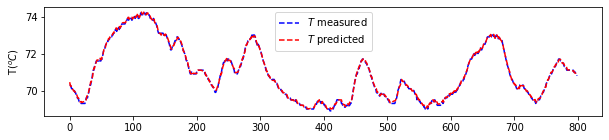

In [11]:
net.eval()
print("RMSE:", eval(net, train_ds)[1].item())
print("R2:  ", eval(net, train_ds)[0].item())
plot(train_ds, (10, 2))

RMSE: 0.07413855195045471
R2:   0.998317539691925


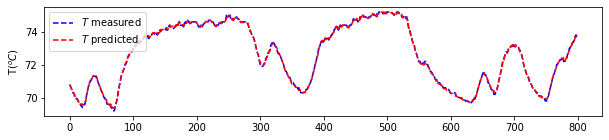

In [12]:
net.eval()
print("RMSE:", eval(net, test_ds)[1].item())
print("R2:  ",   eval(net, test_ds)[0].item())
plot(test_ds, (10, 2))